In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.modeling import models, fitting

%matplotlib inline

In [2]:
#Load the data

#Write your own line function
#Linear, Gaussian, and Blackbody model objects in Astropy.modeling
#Use astroquery to pull info 
#Linear -- 
#Gaussian -- 
#Write a statistic [include links to materials about something other than chi-square]
#Fit with scipy 

#Making simulated data with noise
#Blackbody -- fake the data
#Add Noise
#Fit it
#See if you get the same temp

## Load some data with `astroquery`

In [3]:
## Note from Lia -- I just made some random data that goes in a line for now
xmin, xmax, my_m, my_b, ysig = 0, 100., 3.0, 2.0, 50.0
npoints = 100,
aq_x    = np.random.uniform(xmin, xmax, npoints)
aq_y    = np.random.normal(my_m * aq_x + my_b, ysig)
aq_yerr = np.abs(np.random.normal(0.0, ysig/2.0, npoints))  # Use randomly generated error bars for now

Let's make a scatter plot of the data.

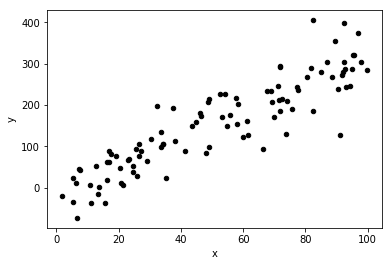

In [4]:
plt.scatter(aq_x, aq_y, s=20, color='k')
plt.xlabel("x")
plt.ylabel("y")

Try using `s=` to change the marker size.

Try changing the [marker](https://matplotlib.org/api/markers_api.html) to a different symbol.

## Write your own line function

Let's write a function that returns a line with slope $m$ and y-intercept $b$, so that $y = mx + b$

In [5]:
def my_line(x, m, b):
    """
    x : input data for the line model
    m : slope of the line model
    b : y-intercept of the line model
    ---
    Returns y = mx + b
    """
    return m * x + b

Now let's set up a grid of $x$ values and evaluate our line function with our favorite $m$ and $b$.  I will use the minimum and maximum values of the data points to define the endpoints of the $x$ grid.

In [6]:
nx    = 1000  # Number of x values to use in our grid
xgrid = np.linspace(np.min(aq_x), np.max(aq_x), nx)

m0, b0 = 1.0, 1.0
model0 = my_line(xgrid, m0, b0)

Now let's plot it with the scatter plot to see how our model compares.

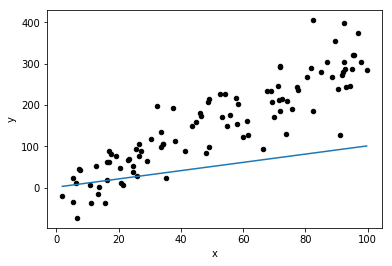

In [7]:
plt.scatter(aq_x, aq_y, s=20, color='k')
plt.xlabel("x")
plt.ylabel("y")

plt.plot(xgrid, model0)

How did it do?  Pick some values of `m0` and `b0` that look good to you.

## Using `astropy.modeling` package to set up a line model

The [astropy.modeling](http://docs.astropy.org/en/stable/modeling/) package contains many analytical functions that are generally useful.  You can find a list of them in [this table](http://docs.astropy.org/en/stable/modeling/#module-astropy.modeling.functional_models)


Let's use one to replace our custom line model function.  We will use the `Linear1D` model object, which we will need to initiate with our favorite $m$ and $b$ values.

In [21]:
linear_model = models.Linear1D(m0, b0)

Now we can evaluate our model by supplying the `linear_model` object with the $x$ values we desire.

Let's plot the linear model with our `xgrid` values, like before.

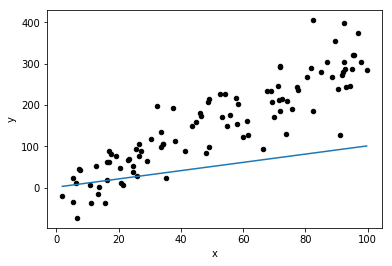

In [22]:
plt.scatter(aq_x, aq_y, s=20, color='k')
plt.xlabel("x")
plt.ylabel("y")

plt.plot(xgrid, linear_model(xgrid))

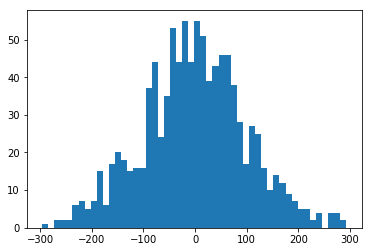

In [8]:
# Generate random data
# To begin, we need to define our Guassian parameters (e.g. the mean and standard deviation)
mean  = 0 # This is our mean
sigma = 100 # This is our standard deviation

# To generate our data, we can use the numpy random generator normal distribution function.
# Let's create 1000 points for now. 
gaussian_data = np.random.normal(mean, sigma, 1000)

# bin data and plot a histogram; overplot your guassian fit
# To visualize our data, let's bin it into 50 bins
bins  = 50
_ = plt.hist(gaussian_data, bins)

#count, bins, ignored = plt.hist(GausData, 30, normed=True)
#plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
#                np.exp( - (bins - mean)**2 / (2 * sigma**2) ),
#          linewidth=2, color='r')
#plt.show()

<Container object of 3 artists>

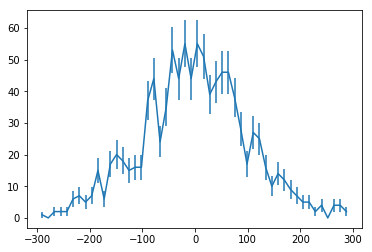

In [9]:
hist_values, bin_edges = np.histogram(gaussian_data, bins)
hist_error = np.sqrt(hist_values)
bin_center = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.errorbar(bin_center, hist_values, yerr=hist_error)

Try playing with the number of data points and see how that changes our error bars. 

## How to simulate a stellar spectrum with noise

In this example, we will simulate a black body spectrum with noise.

First, we will load the [black body module](http://docs.astropy.org/en/stable/modeling/#module-astropy.modeling.blackbody) from `Astropy.modeling`

In [10]:
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu

Now let's set up our model grid for $\lambda$ (the wavelength of the light).  Note that $c = \lambda \nu$, where $\nu$ is the frequency and $c$ is the speed of light.

We will call the variable `wavelength` because `lambda` is a built-in Python construct that we won't be able to use as a variable name.

In [11]:
wmin, wmax = 1000., 10000.  # Angstroms
nbins      = 1000  # Number of bins to use
wavelength = np.linspace(wmin, wmax, nbins) * u.AA  # Angstroms

We'll be using the equation $F_{\lambda} = ???$ with a reasonable temperature for a stellar surface like our sun.

In [12]:
temperature = 6000. * u.K  # Kelvin
intensity_lambda = blackbody_lambda(wavelength, temperature)

Let's see what units were returned by the blackbody function.

In [13]:
print(intensity_lambda.unit)

erg / (Angstrom cm2 s sr)


For a perfectly spherical stellar point source, we multiply the intensity by a factor of $\pi$ (or something) steridians (the sr unit).  

If we want to estimate the number of photon counts in our image, then we also need to multiply the flux by the effective area of our telescope, an exposure time, the energy of the photons as each wavelength, and our bin width.

In [14]:
solid_angle    = np.pi * u.sr
effective_area = 1.e4 * u.cm**2
exposure_time  = 1.0 * 60. * u.s  # 1 minute in units of seconds
photon_energy  = wavelength.to(u.erg, equivalencies=u.spectral())  # See astropy.units tutorial

estimated_counts = intensity_lambda * solid_angle * effective_area * exposure_time / photon_energy

What are the units on estimated_counts?  Why?

Let's get an estimated number of photon counts in each bin

In [15]:
bin_width      = wavelength[1] - wavelength[0]  # Only works if the bins are linearly spaced
counts_per_bin = estimated_counts * bin_width

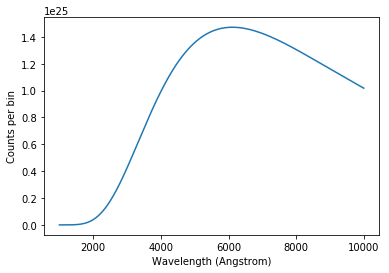

In [16]:
plt.plot(wavelength, counts_per_bin)
plt.xlabel("Wavelength (%s)" % wavelength.unit)
plt.ylabel("Counts per bin")

** Finish this another time **